In [1]:
from dotenv import load_dotenv
from unstructured.partition.pdf import partition_pdf
from IPython.display import Image, display
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
import os, base64, uuid, copy

/home/bishwayansaha99/langchain/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
# current_dir = os.path.dirname(os.path.abspath(__file__))
file_path = os.path.join("./", "docs", "attention.pdf")

chunks = partition_pdf(
    filename=file_path,
    extract_images_in_pdf=True,
    infer_table_structure=True, # Infer table structure
    # strategy='hi_res', # Mandatory for table extraction

    extract_image_block_types=['Image'],
    extract_image_block_to_payload=True, # Extract base64 version of image and metadata
    chunking_strategy='by_title',
    max_characters=10000,
    combine_text_under_n_chars=2000,
    new_after_n_chars=6000
)

print(set([type(chunk) for chunk in chunks]))

{<class 'unstructured.documents.elements.CompositeElement'>}


In [43]:
tables = []
texts = []
images = []

for chunk in chunks:
    text_chunk = copy.copy(chunk)
    chunk_elements = chunk.metadata.orig_elements
    for element in chunk_elements:
        if 'Table' in str(type(element)):
            tables.append(element)
            text_chunk.metadata.orig_elements.remove(element)
        elif 'Image' in str(type(element)):
            images.append(element.metadata.image_base64)
            text_chunk.metadata.orig_elements.remove(element)
    texts.append(text_chunk)    

print(len(images), len(tables), len(texts))

5 4 12


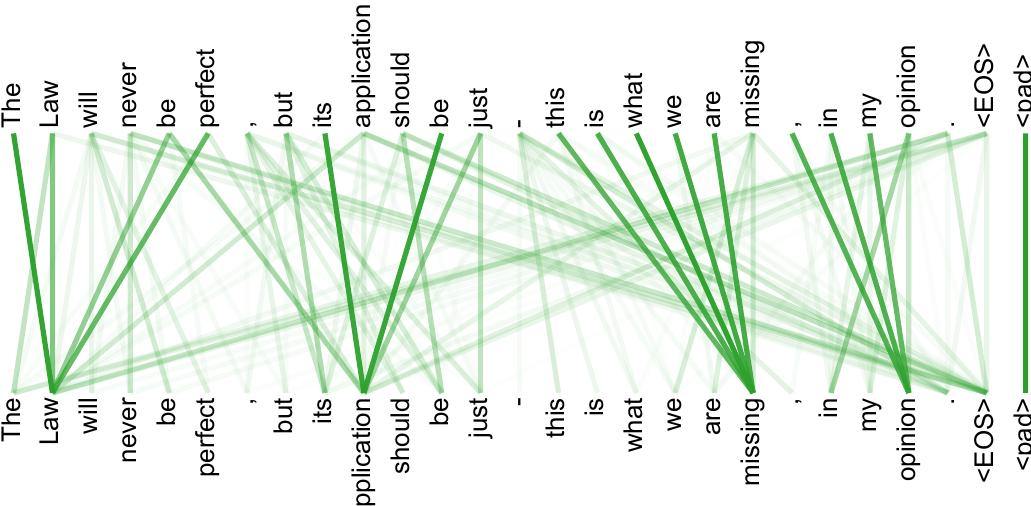

In [21]:
img_data = base64.b64decode(images[4])
display(Image(data=img_data))

In [22]:
prompt_template = ChatPromptTemplate.from_template(
    """
        You are an AI assistant who is expert in summarizing long texts, tables.
        Thereby given data (either text or table), provide a concise summary which holds the internal meaning of actual data.

        While giving response don't add any prefix or suffix phrase like 'Here is the summary' or something like that.
        Just give the summary without any extra keywords and alphanumeric or special keywords.

        Here is the data {element}
    """
)

model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

summarization_chain = prompt_template | model | StrOutputParser()


In [46]:
tables_html = [table.metadata.text_as_html for table in tables]
# print(tables_html)
text_summaries = summarization_chain.batch( texts)
table_summaries = summarization_chain.batch(tables_html)

print(len(table_summaries))
print(table_summaries)
print(len(text_summaries))
print(text_summaries)


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..


4
['Self-attention layers have quadratic complexity but constant sequential operations and path length. Recurrent layers exhibit linear complexity in all aspects. Convolutional layers show linear complexity but logarithmic path length.  Restricted self-attention reduces complexity to linear, with path length linearly dependent on a restriction factor (r).\n', 'Transformer models achieved the highest EN-DE and BLEU EN-FR scores, though with significantly higher training costs.  Ensemble methods generally improved performance across all models, albeit with increased computational expense.  ConvS2S and GNMT+RL consistently showed strong results.\n', "The table presents experimental results, likely from a machine learning context.  Different configurations (A-E) show varying parameters (N, dua, de, hd, dy, Parop, ets, Same) impacting two key metrics:  | (dex) and dev).  Generally,  | (dex) hovers around 5, while dev) is near 25.  Higher values of N, dua, and de tend to correlate with highe

In [48]:
image_prompt = """
    Describe the image in details. For context the image is a part of research paper explaining about transformer
    architecture
"""

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "user", 
            [
                {"type": "text", "text": image_prompt},
                {
                    "type": "image_url",
                    "image_url": {"url": "data:image/jpeg;base64,{image}"}
                }
            ]
        )
    ]
)

image_chain = prompt_template | model | StrOutputParser()

image_summaries = image_chain.batch(images)
print(len(image_summaries))
image_summaries

5


['The image is a diagram illustrating the architecture of a Transformer, a type of neural network architecture commonly used in natural language processing.  The diagram shows two parallel processing paths, labeled "Nx" on the left, representing a sequence of inputs processed in parallel.\n\n**Left Path (Encoder):**\n\nThis path processes the input sequence.  The process starts with:\n\n1. **Inputs:** The raw input data.\n2. **Input Embedding:** The inputs are converted into vector representations (embeddings).\n3. **Positional Encoding:** Information about the position of each word in the sequence is added to the embeddings. This is crucial because Transformers don\'t inherently understand word order.\n4. **Multi-Head Attention:** This layer allows the model to weigh the importance of different words in the input sequence relative to each other.  It identifies relationships between words.\n5. **Add & Norm:** This represents an add and normalize operation.  The output of the Multi-Head

In [49]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
vector_store = Chroma(collection_name="multimodel-rag", embedding_function=embeddings)

store = InMemoryStore()
id_key = "doc_id"

retriever = MultiVectorRetriever(
    vectorstore=vector_store,
    docstore=store,
    id_key=id_key
)

In [50]:
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

image_ids = [str(uuid.uuid4()) for _ in images]
summary_images = [
    Document(page_content=summary, metadata={id_key: image_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_images)
retriever.docstore.mset(list(zip(image_ids, images)))

In [57]:
chunks_res = retriever.invoke("What is transformer architecture?")

chunks_res

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAOAAmADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK5OTxVqWp6pdWPhjSI75LSQw3N/d3PkW6yjrGpCszsO

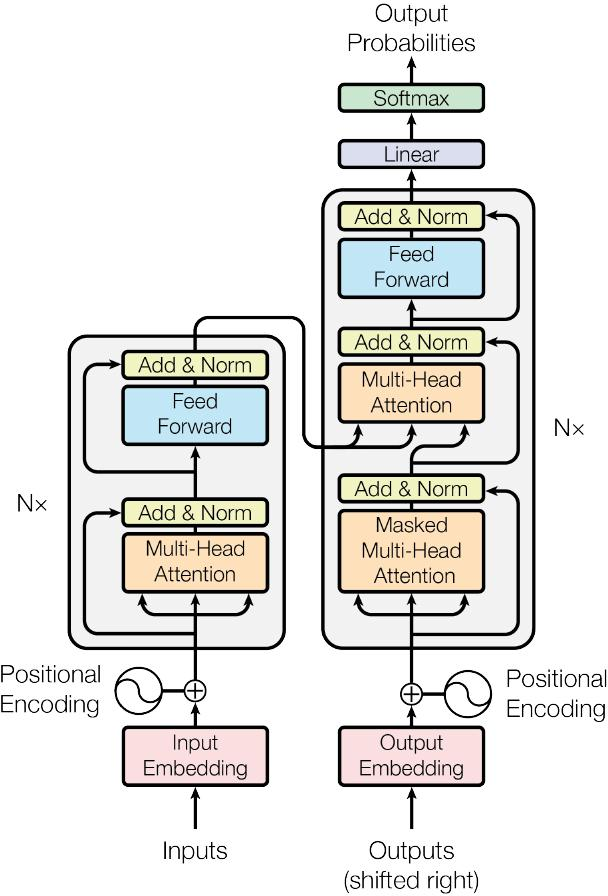

In [36]:
display(Image(data = base64.b64decode(chunks_res[1])))
chunks_res[0].metadata.orig_elements

In [52]:
def parse_docs(docs):
    b64 = []
    text = []
    for doc in docs:
        try:
            base64.b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}

def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | model
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | model
        | StrOutputParser()
    )
)


Response: The Transformer architecture uses an encoder-decoder structure.  The encoder consists of a stack of N=6 identical layers. Each layer contains two sub-layers: a multi-head self-attention mechanism and a position-wise fully connected feed-forward network.  Residual connections and layer normalization are used around each sub-layer. The decoder also has N=6 identical layers, each with three sub-layers: the two from the encoder plus a multi-head attention layer over the encoder's output.  A masking mechanism prevents positions from attending to subsequent positions in the decoder's self-attention sub-layer.  All sub-layers and embedding layers have an output dimension of dmodel = 512.


Context:
3 Model Architecture

Most competitive neural sequence transduction models have an encoder-decoder structure [5, 2, 35]. Here, the encoder maps an input sequence of symbol representations (x1, ..., xn) to a sequence of continuous representations z = (z1, ..., zn). Given z, the decoder the

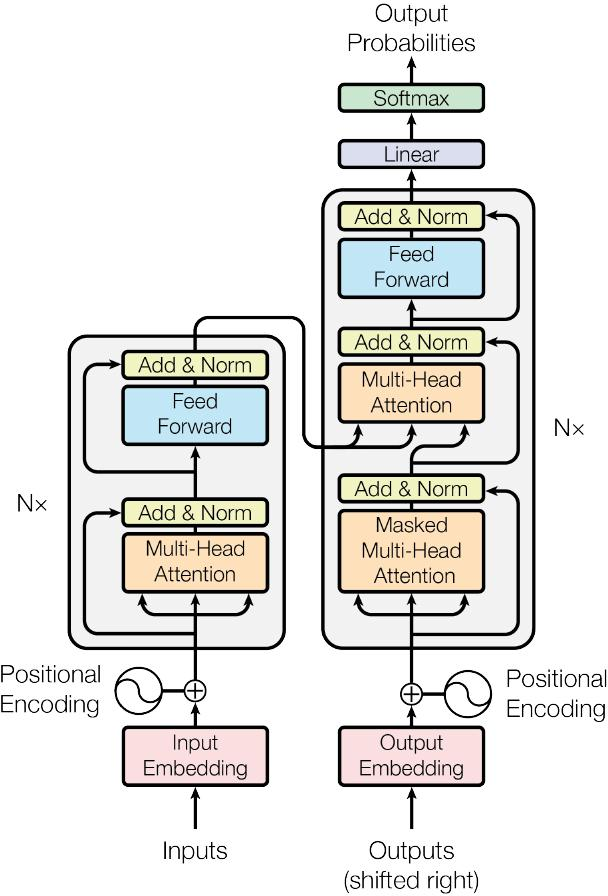

In [58]:
response = chain_with_sources.invoke(
    "What is transformer architecture?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display(Image(data = base64.b64decode(image)))

In [65]:
response

{'context': {'images': [],
  'texts': [<unstructured.documents.elements.CompositeElement at 0x7f31b2cb1760>,
   <unstructured.documents.elements.CompositeElement at 0x7f31b2dd1be0>]},
 'question': 'What is multihead?',
 'response': 'Based on the provided text, multi-head attention is a mechanism that uses multiple parallel attention layers (heads).  Instead of a single attention function with high-dimensional keys, values, and queries, it linearly projects these into lower dimensions  (dk, dk, and dv respectively) using different learned linear projections.  The attention function is then performed on each projected version in parallel, yielding dv-dimensional output values.  These are concatenated and projected again to produce the final output.  This allows the model to attend to information from different representation subspaces at different positions, something a single attention head (with averaging) inhibits.  The paper uses h=8 heads, with dk=dv=dmodel/h=64.\n'}